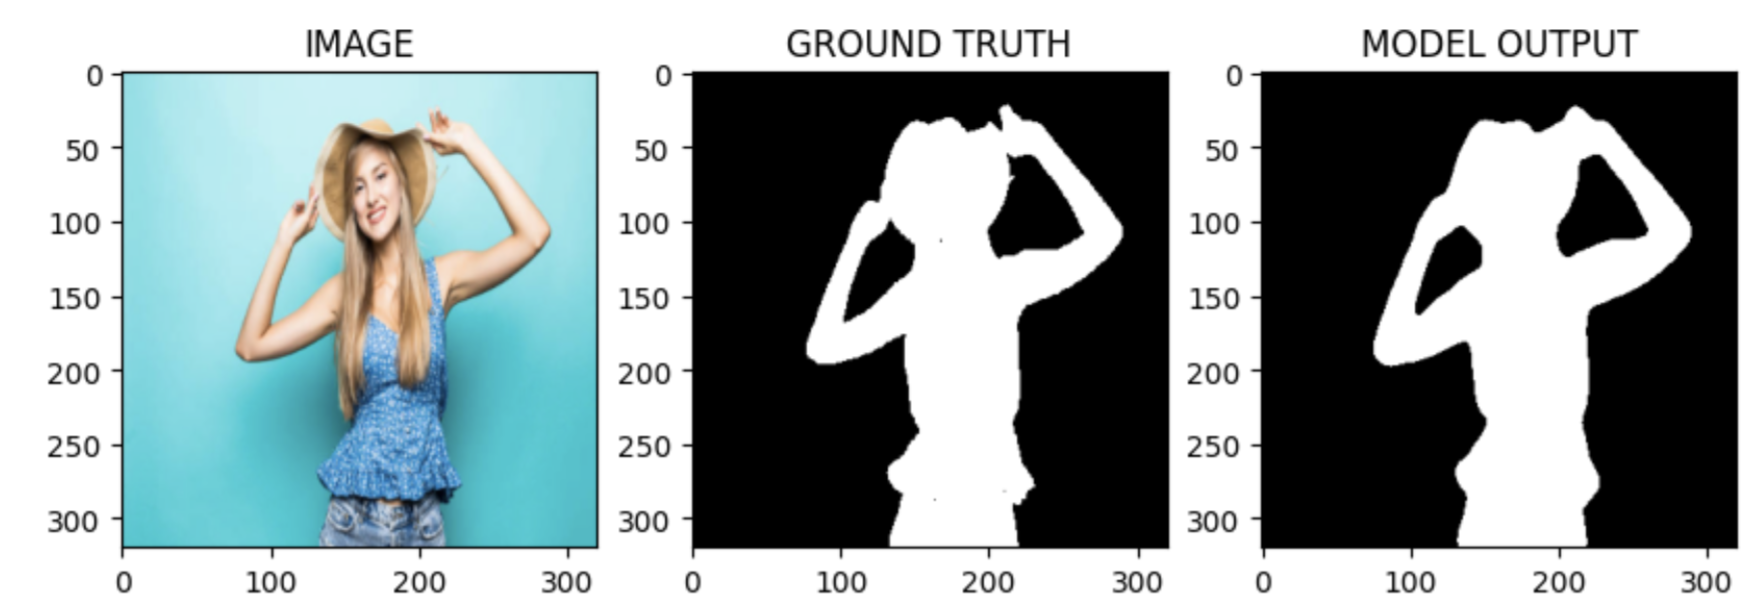

# Person Segemnation Using PyTorch

In this colab note book we will create and train a UNet based image segmentation model in PyTorch and save the model for future inference.
Please note that you need to download saved model as it will be deleted after your colab session expires.

Key steps envolved in creating and training the model are
<h2>Envionment Setup</h2>
<ul>
<li> Setup colab GPU environment </li>
<li> Install of required packacges. </li>
<li> Clone my Github for datasets and Unzip dataset file, alternativly you can use your own dataset with some modifications of path etc. </li>
<li>Append system path to include the temperary folder. </li>
<li> Develop helper method to show images.</li>
</ul>
<h2> Core Network Developement and Testing.</h2>
<ul>
<li>Set network configuration parameters.</li>
<li>Read CSV file for paths of Images and associated Ground Truth. </li>
<li>Split data into test and validation set.</li>
<li>Split data into test and validation set.</li>
<li>Define data augmentation functions.</li>
<li>Create a custom dataset with data augmentation.</li>
<li>Load dataset into batches with PyTorch data loader.</li>
<li>Create segmentation model.</li>
<li>Create training and validation function.</li>
<li>Train and save the model.</li>
<li>Inference.</li>
</ul>


##Envionment Setup

### Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-9929pgiu
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-9929pgiu
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


### Download  and Unzip Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
print ("Cloning Dataset Reposotory...\n")
!git clone https://github.com/sindhurakshit/HumanSegNet.git
print ("Cloning Dataset Reposotory...\n")
print ("Downloading Dataset..\n")
print("Unziping dataset... \n")
!unzip  -oq	HumanSegNet/Human-Segmentation-Dataset.zip  # silent unzip
print("Unzip dataset completed.")

Cloning Dataset Reposotory...

fatal: destination path 'HumanSegNet' already exists and is not an empty directory.
Cloning Dataset Reposotory...


Unziping dataset... 

Unzip dataset completed.


### Append system path and import packages

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Helper function to show images

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')




## Core Network Development and Training

 ### Set network configuration parameters

In [6]:
CSV_FILE='/content/Human-Segmentation-Dataset/train.csv'
DATA_DIR='/content/'
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')
EPOCHS = 25
LR= 0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER ='timm-efficientnet-b0'
WEIGHTS='imagenet'


### Read CSV file for paths of Images and associated Ground Truth

In [7]:
#torch.set_default_device(DEVICE)
df = pd.read_csv(CSV_FILE)
df.head()


,masks,images
0,Human-Segmentation-Dataset/Ground_Truth/1.png,Human-Segmentation-Dataset/Training_Images/1.jpg
1,Human-Segmentation-Dataset/Ground_Truth/10.png,Human-Segmentation-Dataset/Training_Images/10.jpg
2,Human-Segmentation-Dataset/Ground_Truth/100.png,Human-Segmentation-Dataset/Training_Images/100...
3,Human-Segmentation-Dataset/Ground_Truth/101.png,Human-Segmentation-Dataset/Training_Images/101...
4,Human-Segmentation-Dataset/Ground_Truth/102.png,Human-Segmentation-Dataset/Training_Images/102...


In [8]:
index=4
row = df.iloc[index]
image_path=row.images
mask_path = row.masks

image= cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert BGR image read by cv2 to RGB

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0


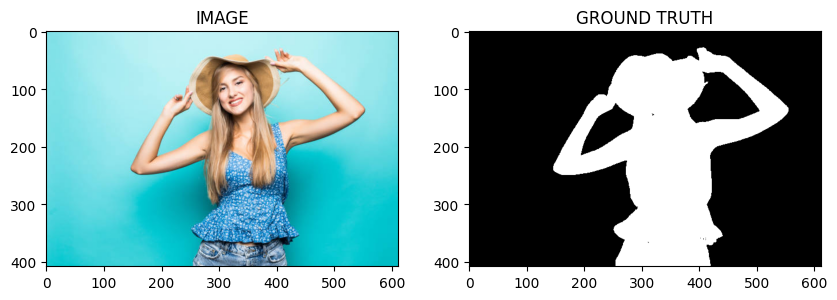

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

### Split data into test and validation set

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2)

### Define data augmentation functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.5),],is_check_shapes=False) # is_check_shapes=False
def get_val_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),],is_check_shapes=False) #is_check_shapes=False

### Create custom dataset with data augmentation

In [13]:
from torch.utils.data import Dataset


In [14]:
class PersonSegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert BGR image read by cv2 to RGB

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #mask is in [ h, w] form add channel to it [h, w,c]
    mask = np.expand_dims(mask, axis=-1)

    # Apply albumentations is applicable
    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # convert  image and mask from [h,w,c]--> [c,h,w]
    image= np.transpose(image,(2,0,1))
    mask= np.transpose(mask,(2,0,1))

    # convert them to torch tensor and normalise

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask




In [15]:
trainset = PersonSegmentationDataset(train_df, get_train_augs())
validset = PersonSegmentationDataset(val_df, get_val_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


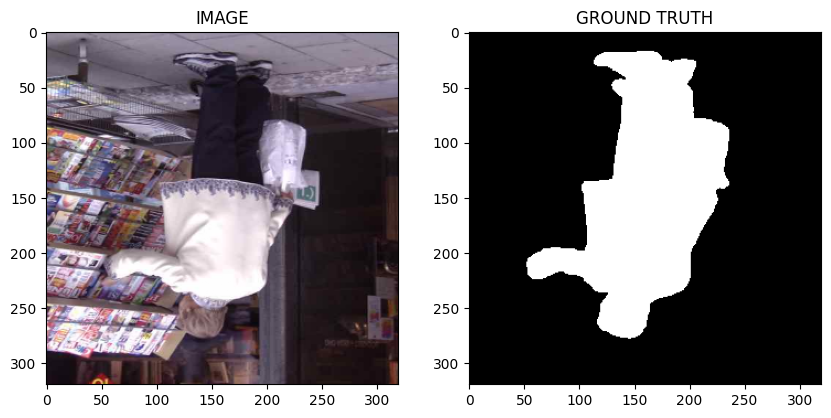

In [17]:
idx=21
image, mask=trainset[idx]
show_image(image,mask)

### Load dataset into batches with pytorch dataloader

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader =  DataLoader(validset,batch_size=BATCH_SIZE,)

#trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,generator=torch.Generator(device='cuda'))
#validloader =  DataLoader(validset,batch_size=BATCH_SIZE,generator=torch.Generator(device='cuda'))

In [20]:
print(f'Total number of batches in train loader : {len(trainloader)}')
print(f'Total number of batches in Valid loader : {len(validloader)}')

Total number of batches in train loader : 15
Total number of batches in Valid loader : 4


In [21]:
for image, mask in trainloader:
  break
print(f' One batch image shape {image.shape}')
print(f' One batch mask shape {mask.shape}')


 One batch image shape torch.Size([16, 3, 320, 320])
 One batch mask shape torch.Size([16, 1, 320, 320])


### Create segmentation model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class PersonSegmentationModel(nn.Module):
  def __init__(self):
    super(PersonSegmentationModel, self).__init__()
    self.arc = smp.Unet(encoder_name=ENCODER,
                        encoder_weights=WEIGHTS,
                        in_channels=3,
                        classes=1,
                        activation=None,
                        )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits, masks)
      loss2= nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits


In [24]:
model=PersonSegmentationModel()
model.to(DEVICE)

PersonSegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
     

### Create training and validation function

In [25]:
def train_net(dataloader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(dataloader):
    images =images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits , loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()
  return total_loss/len(dataloader)

In [26]:
def eval_net(dataloader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images =images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits , loss = model(images, masks)
      total_loss +=loss.item()
  return total_loss/len(dataloader)

###Train and save model

In [27]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [28]:
best_valid_loss=np.Inf
for i in range (EPOCHS):
  train_loss=train_net(trainloader, model, optimizer)
  valid_loss= eval_net(validloader, model)
  if valid_loss <best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved")
    best_valid_loss=valid_loss
  print(f'ECPOCH : {i+1} Training Loss : {train_loss}, Validation Loss : {valid_loss}')


100%|██████████| 4/4 [00:01<00:00,  3.71it/s]


Model saved
ECPOCH : 1 Training Loss : 0.7612700541814168, Validation Loss : 0.7000839784741402


100%|██████████| 4/4 [00:01<00:00,  3.54it/s]


ECPOCH : 2 Training Loss : 0.35688398977120717, Validation Loss : 1.2192375361919403


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


Model saved
ECPOCH : 3 Training Loss : 0.3168494741121928, Validation Loss : 0.2134331539273262


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


Model saved
ECPOCH : 4 Training Loss : 0.2612381488084793, Validation Loss : 0.15694704465568066


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Model saved
ECPOCH : 5 Training Loss : 0.23039589325586954, Validation Loss : 0.15504205413162708


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


ECPOCH : 6 Training Loss : 0.2412231852610906, Validation Loss : 0.25454314425587654


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


Model saved
ECPOCH : 7 Training Loss : 0.20498886903127034, Validation Loss : 0.12031745165586472


100%|██████████| 4/4 [00:00<00:00,  4.36it/s]


ECPOCH : 8 Training Loss : 0.22255937655766805, Validation Loss : 0.12700350023806095


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Model saved
ECPOCH : 9 Training Loss : 0.19577946662902831, Validation Loss : 0.11479765921831131


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Model saved
ECPOCH : 10 Training Loss : 0.20390290766954422, Validation Loss : 0.10740313678979874


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Model saved
ECPOCH : 11 Training Loss : 0.17694603701432546, Validation Loss : 0.09822995960712433


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Model saved
ECPOCH : 12 Training Loss : 0.14110374301671982, Validation Loss : 0.08826870657503605


100%|██████████| 4/4 [00:01<00:00,  3.24it/s]


ECPOCH : 13 Training Loss : 0.12990547269582747, Validation Loss : 0.08873508684337139


100%|██████████| 4/4 [00:00<00:00,  5.89it/s]


Model saved
ECPOCH : 14 Training Loss : 0.12860404402017594, Validation Loss : 0.08215631358325481


100%|██████████| 4/4 [00:00<00:00,  5.72it/s]


Model saved
ECPOCH : 15 Training Loss : 0.1127259815732638, Validation Loss : 0.07444496732205153


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


ECPOCH : 16 Training Loss : 0.18919022381305695, Validation Loss : 0.10092851612716913


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


ECPOCH : 17 Training Loss : 0.1696187416712443, Validation Loss : 0.22408650070428848


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


ECPOCH : 18 Training Loss : 0.14128651320934296, Validation Loss : 0.07958401367068291


100%|██████████| 4/4 [00:00<00:00,  5.88it/s]


Model saved
ECPOCH : 19 Training Loss : 0.12591387927532197, Validation Loss : 0.07146250735968351


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


ECPOCH : 20 Training Loss : 0.15554886559645334, Validation Loss : 0.08001202158629894


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


ECPOCH : 21 Training Loss : 0.1411045655608177, Validation Loss : 0.08399468287825584


100%|██████████| 4/4 [00:00<00:00,  5.63it/s]


ECPOCH : 22 Training Loss : 0.11218788673480352, Validation Loss : 0.07233787979930639


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Model saved
ECPOCH : 23 Training Loss : 0.09758710116147995, Validation Loss : 0.06760578975081444


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


ECPOCH : 24 Training Loss : 0.11316054761409759, Validation Loss : 0.06962235178798437


100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

ECPOCH : 25 Training Loss : 0.10912918200095495, Validation Loss : 0.07686792965978384


###Inference

In [29]:
index=4
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[index]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) ---> (1, C, H,W) , 1 for batch
pred_mask= torch.sigmoid(logits_mask)  # as we have not used sigmoid in pred function
pred_mask = (pred_mask>0.5)*1.0   # convert any pixel less greater than .5 to 1


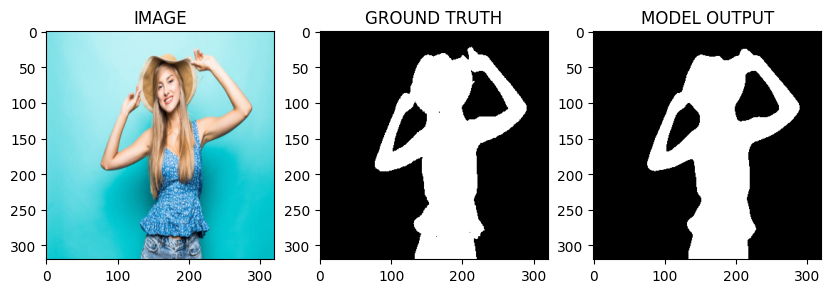

In [30]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # detach and remove batch info added earlier